In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine, plot_bootstrap_timeseries
from phase_precession import cl_corr
from spike_statistics.core import permutation_resampling
import matplotlib.mlab as mlab
import scipy.signal as ss
from scipy.interpolate import interp1d
from septum_mec.analysis.plotting import regplot
from skimage import measure
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import scipy.signal as ss


from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

import pycwt

10:24:57 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a', '#4393c3', '#d6604d']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz', 'Baseline', 'Stimulated']
plt.rcParams['figure.dpi'] = 150
figsize_violin = (1.7, 3)
figsize_speed = (4, 3)
plt.rc('axes', titlesize=10)

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "lfp_speed"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [5]:
data_action = actions['lfp_speed']
output = exdir.File(
    data_action.data_path('results'),
    plugins = [exdir.plugins.git_lfs, exdir.plugins.quantities])

ignore = ['wavelet_power', 'wavelet_freqs', 'signal']
results = []
for group in output.values():
    d = group.attrs.to_dict()
    d.update({k: np.array(v.data) for k, v in group.items() if k not in ignore})
    results.append(d)
results = pd.DataFrame(results)

In [6]:
results.head()

,freq_score,sample_rate,power_score,action,channel_group,max_speed,min_speed,position_low_pass_frequency,mean_freq,mean_power,speed,speed_bins,theta_freq,theta_power
0,0.191729,1000.0,0.432532,1833-010719-1,0,1,0.02,6,"[7.154332133229601, 7.106500202042717, 7.13862...","[18.005621200653046, 18.66435212100411, 20.504...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.990633076071412, 3.992883430179942, 3.99513..."
1,0.255882,1000.0,0.434938,1833-010719-1,1,1,0.02,6,"[7.035831237674811, 7.05973079549096, 7.120455...","[16.966011451769536, 17.60417640800431, 19.452...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.649171825378523, 3.6511305369806806, 3.6530..."
2,0.169116,1000.0,0.338942,1833-010719-1,2,1,0.02,6,"[7.156957284750235, 7.121730043055997, 7.17760...","[14.747162413722597, 15.548073560884317, 16.81...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.069575227276876, 3.0713927350182493, 3.0732..."
3,0.071480,1000.0,0.141405,1833-010719-1,3,1,0.02,6,"[7.256682286107137, 7.237350035531646, 7.27254...","[13.017027147293039, 12.651121743582284, 13.91...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.399999999999999, 6.399999999999999, 6.39999...","[1.9508693636836856, 1.9523977795413874, 1.953..."
4,0.216792,1000.0,-0.012191,1833-010719-1,4,1,0.02,6,"[7.095817125902336, 7.050223640391819, 7.12869...","[32.456068185302364, 23.01562486642484, 21.395...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.399999999999999, 6.399999999999999, 6.39999...","[1.2545438245339104, 1.2553897239251606, 1.256..."


In [7]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [8]:
results = results.merge(sessions, on='action')

# Frequency score

In [9]:
query_base_i = 'baseline and Hz11'
query_stim_11 = 'stimulated and Hz11'

query_base_ii = 'baseline and Hz30'
query_stim_30 = 'stimulated and Hz30'

query_stim_combined = 'stimulated and Hz11 or Hz30'

U-test: U value 37221.0 p value 1.9679601390031718e-50
U-test: U value 16950.0 p value 1.642880876541107e-32
U-test: U value 72140.0 p value 2.0364061218728567e-30


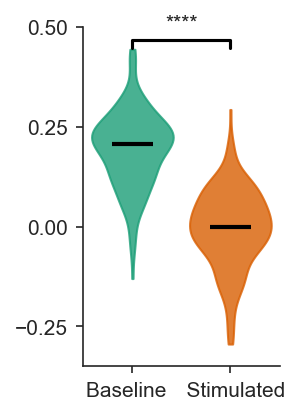

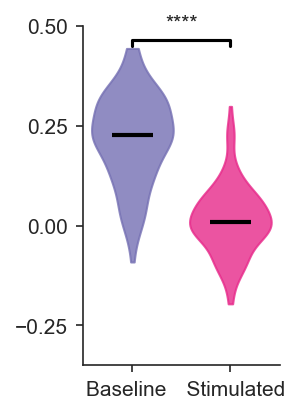

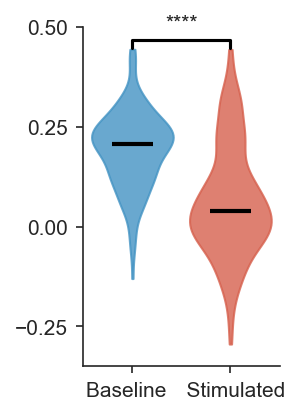

In [37]:
stuff = 'freq_score'
base = results.query(query_base_i)[stuff].to_numpy()
stim = results.query(query_stim_11)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors)
plt.ylim(-0.35, 0.5)
plt.yticks([-0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "frequency_score_11.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "frequency_score_11.png", bbox_inches="tight", transparent=True)

base = results.query(query_base_ii)[stuff].to_numpy()
stim = results.query(query_stim_30)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors[2:])
plt.ylim(-0.35, 0.5)
plt.yticks([-0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "frequency_score_30.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "frequency_score_30.png", bbox_inches="tight", transparent=True)

base = results.query(query_base_i)[stuff].to_numpy()
stim = results.query(query_stim_combined)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors[4:])
plt.ylim(-0.35, 0.5)
plt.yticks([-0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "frequency_score_combined.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "frequency_score_combined.png", bbox_inches="tight", transparent=True)

In [38]:
def plot_speed(query_base, query_stim, stuff, colors, labels, filename=None, show_raw=False, ylim=None):
    base = np.array([s for s in results.query(query_base)[stuff]])
    base_bins = results.query(query_base)['speed_bins'].to_numpy()

    stim = np.array([s for s in results.query(query_stim)[stuff]])
    stim_bins = results.query(query_stim)['speed_bins'].to_numpy()
    if show_raw:
        fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)

        for b, h in zip(base_bins, base):
            axs[1].plot(b, h)
            axs[1].set_xlim(0.1,1)
            axs[1].set_title(labels[0])

        for b, h in zip(stim_bins, stim):
            axs[0].plot(b, h)
            axs[0].set_xlim(0.1,1)
            axs[0].set_title(labels[1])  

    fig, ax = plt.subplots(1, 1, figsize=figsize_speed)
    plot_bootstrap_timeseries(base_bins[0], base.T, ax=ax, label=labels[0], color=colors[0])
    plot_bootstrap_timeseries(stim_bins[0], stim.T, ax=ax, label=labels[1], color=colors[1])

    plt.xlim(0, 0.9)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(frameon=False)
    if ylim is not None:
        plt.ylim(ylim)
    despine()
    if filename is not None:
        plt.savefig(output_path / "figures" / f"{filename}.svg", bbox_inches="tight", transparent=True)
        plt.savefig(output_path / "figures" / f"{filename}.png", bbox_inches="tight", transparent=True)

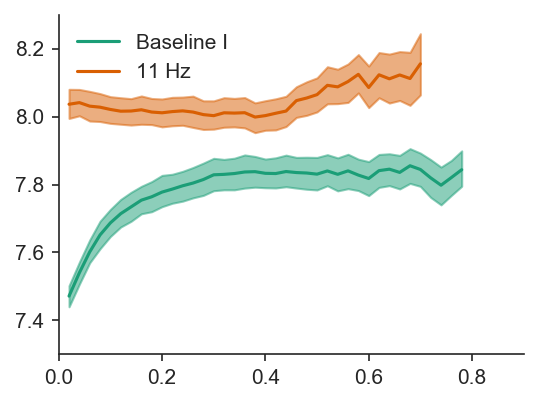

In [39]:
plot_speed(query_base_i, query_stim_11, 'mean_freq', 
           colors, labels, filename='lfp_speed_freq_11', ylim=(7.3, 8.3))

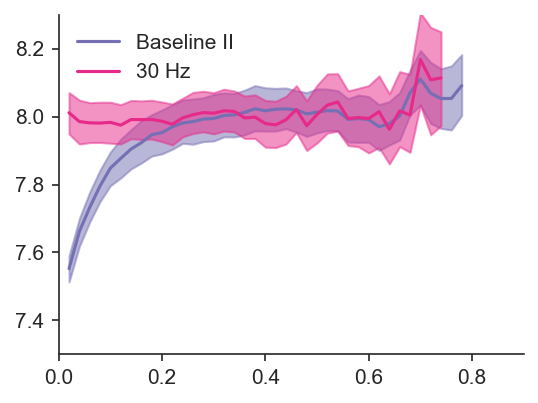

In [40]:
plot_speed(query_base_ii, query_stim_30, 'mean_freq', 
           colors[2:], labels[2:], filename='lfp_speed_freq_30', ylim=(7.3, 8.3))

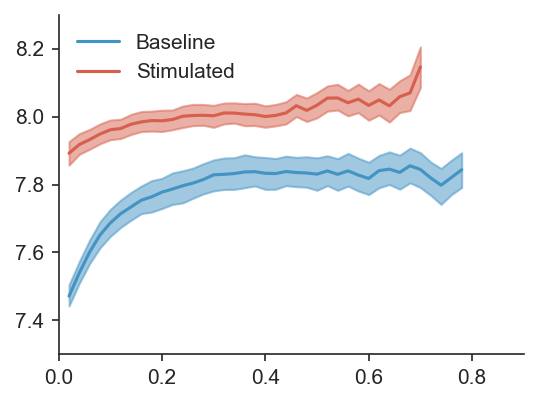

In [41]:
plot_speed(
    query_base_i, query_stim_combined, 'mean_freq', 
    colors[4:], labels[4:], filename='lfp_speed_freq_combined', ylim=(7.3, 8.3))

# Power Familiar

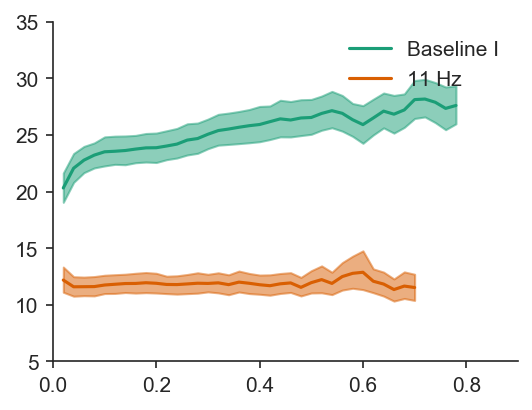

In [42]:
plot_speed(
    query_base_i, query_stim_11, 'mean_power', 
    colors, labels, filename='lfp_speed_power_11', ylim=(5, 35))

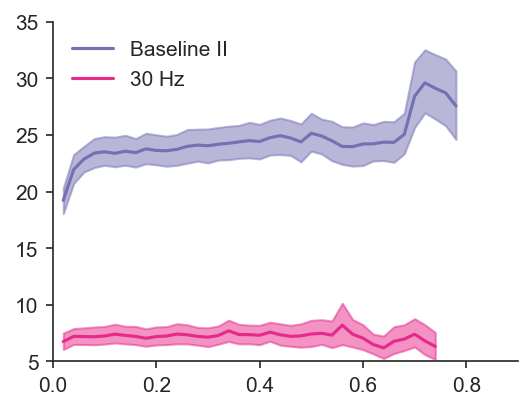

In [43]:
plot_speed(
    query_base_ii, query_stim_30, 'mean_power', 
    colors[2:], labels[2:], filename='lfp_speed_power_30', ylim=(5, 35))

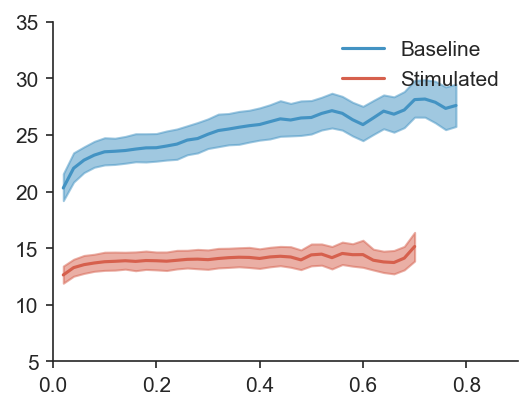

In [44]:
plot_speed(
    query_base_i, query_stim_combined, 'mean_power', 
    colors[4:], labels[4:], filename='lfp_speed_power_combined', ylim=(5, 35))

U-test: U value 32624.0 p value 6.282441580666677e-28
U-test: U value 12586.0 p value 2.6741470157506103e-07
U-test: U value 67804.0 p value 1.2329632916124497e-21


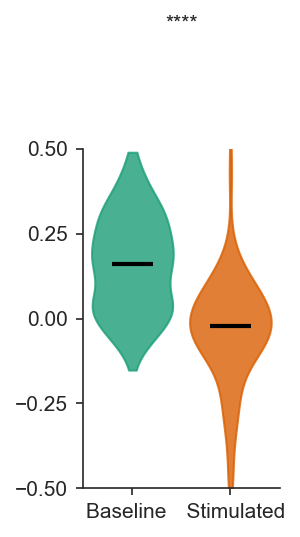

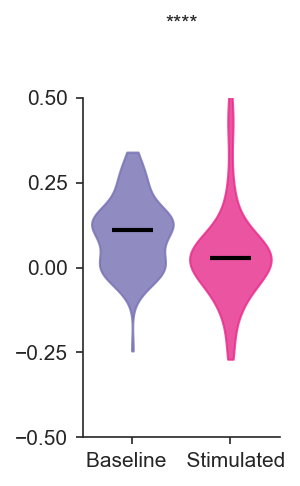

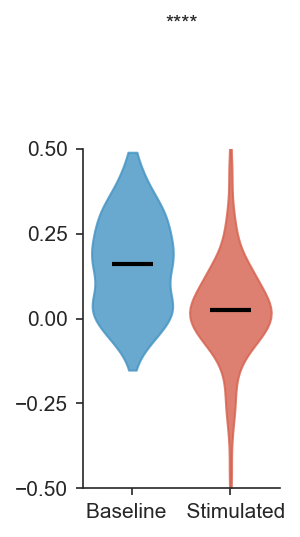

In [36]:
stuff = 'power_score'
base = results.query(query_base_i)[stuff].to_numpy()
stim = results.query(query_stim_11)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors)
plt.ylim(-0.5, 0.5)
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "power_score_11.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "power_score_11.png", bbox_inches="tight", transparent=True)

base = results.query(query_base_ii)[stuff].to_numpy()
stim = results.query(query_stim_30)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors[2:])
plt.ylim(-0.5, 0.5)
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "power_score_30.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "power_score_30.png", bbox_inches="tight", transparent=True)

base = results.query(query_base_i)[stuff].to_numpy()
stim = results.query(query_stim_combined)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(base, stim, colors=colors[4:])
plt.ylim(-0.5, 0.5)
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5])
despine()
plt.savefig(output_path / "figures" / "power_score_combined.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "power_score_combined.png", bbox_inches="tight", transparent=True)

# Speed

U-test: U value 31872.0 p value 4.112172727188835e-10


IndexError: list index out of range

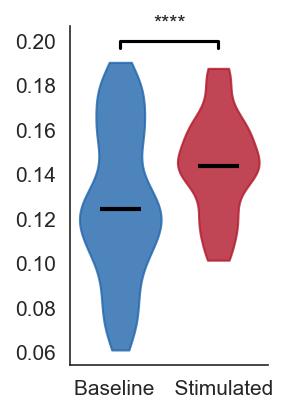

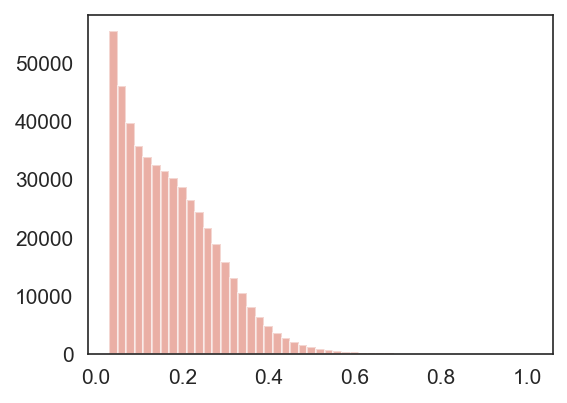

In [18]:
stuff = 'speed'
min_speed = results['min_speed'].iloc[0]
max_speed = results['max_speed'].iloc[0]

f = np.median
base = np.array([f(a) for a in results.query(query_base_i)[stuff]])
stim = np.array([f(a).mean() for a in results.query(query_stim_combined)[stuff]])
plt.figure(figsize=figsize_violin)
violinplot(stim, base)

plt.savefig(output_path / "figures" / "speed.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "speed.png", bbox_inches="tight", transparent=True)

plt.figure(figsize=figsize_speed)
binsize = 0.02
bins = np.arange(min_speed, max_speed + binsize, binsize)
base = np.array([np.histogram(a, bins)[0] for a in results.query(query_base_i)[stuff]])
stim = np.array([np.histogram(a, bins)[0]  for a in results.query(query_stim_combined)[stuff]])

plt.bar(bins[1:], stim.mean(axis=0), width=np.diff(bins)[0], label='Stimulated', alpha=.5, color=colors[5]);
plt.bar(bins[1:], base.mean(axis=0), width=np.diff(bins)[0], label='Baseline', alpha=.5, color=colors[6]);

plt.legend(frameon=False)

plt.savefig(output_path / "figures" / "speed_histogram.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "speed_histogram.png", bbox_inches="tight", transparent=True)

# Table

In [26]:
columns = [
    'power_score',
    'freq_score'
]


def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(column, query1, query2):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        results.query(query1)[column].dropna(), 
        results.query(query2)[column].dropna(),
        alternative='two-sided')
    
    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, query1, query2):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        results.query(query1)[column].dropna(), 
        results.query(query2)[column].dropna(), statistic=np.median)
    
    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)

summary_i = pd.DataFrame()

summary_i['Baseline I'] = results.query(query_base_i)[columns].agg(summarize)
summary_i['11 Hz'] = results.query(query_stim_11)[columns].agg(summarize)

summary_i['MWU'] = list(map(lambda x: MWU(x, query_base_i, query_stim_11), columns))
summary_i['PRS'] = list(map(lambda x: PRS(x, query_base_i, query_stim_11), columns))

summary_ii = pd.DataFrame()

summary_ii['Baseline II'] = results.query(query_base_ii)[columns].agg(summarize)
summary_ii['30 Hz'] = results.query(query_stim_30)[columns].agg(summarize)

summary_ii['MWU'] = list(map(lambda x: MWU(x, query_base_ii, query_stim_30), columns))
summary_ii['PRS'] = list(map(lambda x: PRS(x, query_base_ii, query_stim_30), columns))

summary_combined = pd.DataFrame()

summary_combined['Baseline I'] = results.query(query_base_i)[columns].agg(summarize)
summary_combined['Combined'] = results.query(query_stim_combined)[columns].agg(summarize)

summary_combined['MWU'] = list(map(lambda x: MWU(x, query_base_i, query_stim_combined), columns))
summary_combined['PRS'] = list(map(lambda x: PRS(x, query_base_i, query_stim_combined), columns))

summary_i.to_latex(output_path / "statistics" / "power_freq_score_summary_i.tex")
summary_i.to_csv(output_path / "statistics" / "power_freq_score_summary_i.csv")

summary_ii.to_latex(output_path / "statistics" / "power_freq_score_summary_ii.tex")
summary_ii.to_csv(output_path / "statistics" / "power_freq_score_summary_ii.csv")

summary_combined.to_latex(output_path / "statistics" / "power_freq_score_summary_combined.tex")
summary_combined.to_csv(output_path / "statistics" / "power_freq_score_summary_combined.csv")

In [27]:
summary_i

,Baseline I,11 Hz,MWU,PRS
power_score,0.16 ± 0.01 (192),-0.03 ± 0.01 (208),"32624.00, 0.000","0.18, 0.000"
freq_score,0.19 ± 0.01 (192),-0.01 ± 0.01 (208),"37221.00, 0.000","0.21, 0.000"


In [28]:
summary_ii

,Baseline II,30 Hz,MWU,PRS
power_score,0.10 ± 0.01 (136),0.04 ± 0.01 (136),"12586.00, 0.000","0.08, 0.000"
freq_score,0.22 ± 0.01 (136),0.01 ± 0.01 (136),"16950.00, 0.000","0.22, 0.000"


In [29]:
summary_combined

,Baseline I,Combined,MWU,PRS
power_score,0.16 ± 0.01 (192),0.03 ± 0.01 (480),"67804.00, 0.000","0.13, 0.000"
freq_score,0.19 ± 0.01 (192),0.06 ± 0.01 (480),"72140.00, 0.000","0.17, 0.000"


# Register in expipe

In [30]:
action = project.actions["lfp_speed"]

In [31]:
outdata = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in outdata.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [32]:
septum_mec.analysis.registration.store_notebook(action, "20_lfp_speed.ipynb")